Here we've got no predefined dataset, just bunch of cats and dogs photos in `data/images/` named like `catxxx.jpg` and `dogxxx.jpg` where xxx is number. Totally there are 3000 images divided evenly between cats and dogs. We'll use 1000 images for train and 500 for validation for each of this two classes. Dogs  will be labeled 1, cats 0. 

In [20]:
from os import listdir
from os.path import isfile, join

datapath = "./data/images/"

file_names = [f for f in listdir(datapath) if isfile(join(datapath, f))]

print(len(file_names), " images loaded")

3000  images loaded


'cat.13.jpg'

In [22]:
import cv2
import numpy as np
import sys
import shutil

dog_count = 0
cat_count = 0
training_size = 1000
test_size = 500
total_size = training_size + test_size
training_images = []
training_labels = []
test_images = []
test_labels = []

size = 150 # all images will be 150x150
dog_dir_train = "./data/train/dogs/"
cat_dir_train = "./data/train/cats/"
dog_dir_test = "./data/test/dogs/"
cat_dir_test = "./data/test/cats/"

for directory in [dog_dir_train, dog_dir_test, cat_dir_test, cat_dir_train]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

In [25]:
for i, file in enumerate(file_names):
    if file.startswith('dog'):
        dog_count += 1
        image = cv2.imread(datapath+file)
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            cv2.imwrite("{}dog{:03d}.jpg".format(dog_dir_train, dog_count), image)
        elif dog_count > training_size and dog_count <= total_size:
            test_images.append(image)
            test_labels.append(1)
            cv2.imwrite("{}dog{:03d}.jpg".format(dog_dir_test, dog_count), image)

    elif file.startswith('cat'):
        cat_count += 1
        image = cv2.imread(datapath+file)
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            cv2.imwrite("{}cat{:03d}.jpg".format(cat_dir_train, cat_count), image)
        elif cat_count > training_size and cat_count <= total_size:
            test_images.append(image)
            test_labels.append(0)
            cv2.imwrite("{}cat{:03d}.jpg".format(cat_dir_test, cat_count), image)

    if dog_count == total_size and cat_count == total_size:
        break

print("Test/train split completed")

Test/train split completed


In [26]:
y_train = np.array(training_labels)
y_train = y_train.reshape(y_train.shape[0], 1)

y_test = np.array(test_labels)
y_test = y_test.reshape(y_test.shape[0], 1)

x_train = np.array(training_images).astype('float32') / 255
x_test = np.array(test_images).astype('float32') / 255

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(size, size, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train, batch_size=16, epochs=25, validation_data=(x_test, y_test), shuffle=True)

Train on 2000 samples, validate on 1000 samples
Epoch 1/25
2000/2000 [==============================] - 38s 19ms/step - loss: 0.7035 - accuracy: 0.5330 - val_loss: 0.6806 - val_accuracy: 0.6300
Epoch 2/25
2000/2000 [==============================] - 40s 20ms/step - loss: 0.6690 - accuracy: 0.6135 - val_loss: 0.6320 - val_accuracy: 0.6640
Epoch 3/25
2000/2000 [==============================] - 39s 20ms/step - loss: 0.6066 - accuracy: 0.6895 - val_loss: 0.6748 - val_accuracy: 0.5850
Epoch 4/25
2000/2000 [==============================] - 39s 20ms/step - loss: 0.5609 - accuracy: 0.7290 - val_loss: 0.5940 - val_accuracy: 0.6780
Epoch 5/25
2000/2000 [==============================] - 40s 20ms/step - loss: 0.5133 - accuracy: 0.7545 - val_loss: 0.6024 - val_accuracy: 0.7100
Epoch 6/25
2000/2000 [==============================] - 40s 20ms/step - loss: 0.4512 - accuracy: 0.7945 - val_loss: 0.7190 - val_accuracy: 0.6690
Epoch 7/25
2000/2000 [==============================] - 40s 20ms/step - loss

In [34]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss ", score[0])
print("Test acc", score[1])

1000/1000 [==============================] - 5s 5ms/step
Test loss  2.014238723754883
Test acc 0.6759999990463257


Now use data augmentation tecnhique

In [38]:
from keras.preprocessing.image import ImageDataGenerator

nb_train_samples = 2000
nb_test_samples = 1000
batch_size = 16
epochs = 25

train_data_dir = './data/train'
test_data_dir = './data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest' 
    )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(size,size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(size,size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 1998 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Model remains with same architecture

In [37]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(size, size, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['accuracy'])

In [39]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=nb_test_samples//batch_size)

Epoch 1/25
125/125 [==============================] - 45s 363ms/step - loss: 0.7118 - accuracy: 0.5045 - val_loss: 0.6649 - val_accuracy: 0.4950
Epoch 2/25
125/125 [==============================] - 43s 345ms/step - loss: 0.6987 - accuracy: 0.5125 - val_loss: 0.5376 - val_accuracy: 0.5030
Epoch 3/25
125/125 [==============================] - 43s 347ms/step - loss: 0.6891 - accuracy: 0.5526 - val_loss: 0.5635 - val_accuracy: 0.6179
Epoch 4/25
125/125 [==============================] - 44s 349ms/step - loss: 0.6736 - accuracy: 0.5891 - val_loss: 0.6091 - val_accuracy: 0.6026
Epoch 5/25
125/125 [==============================] - 43s 346ms/step - loss: 0.6706 - accuracy: 0.6076 - val_loss: 0.8366 - val_accuracy: 0.6230
Epoch 6/25
125/125 [==============================] - 44s 349ms/step - loss: 0.6704 - accuracy: 0.5816 - val_loss: 0.6244 - val_accuracy: 0.6392
Epoch 7/25
125/125 [==============================] - 43s 346ms/step - loss: 0.6466 - accuracy: 0.6276 - val_loss: 0.4929 - val_ac

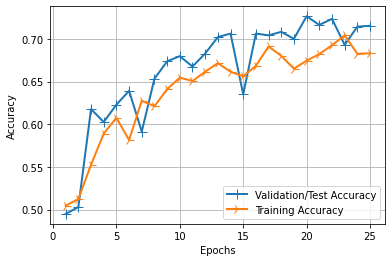

In [42]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Well, +4% of accuracy is not such a big deal, but my goal was just to get along with data augmentations in keras